In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import models
import loss
import metrics
import train_epoch
import val_epoch
import utils

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tMore checkpoints.\n' +
            f'\t{config.EPOCHS} epochs.\n' +
            '\tDataset images divided by 256.\n' +
            '\tAffine True for all BatchNorm Modules: fixed, as I forgot one module in previous experiment.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

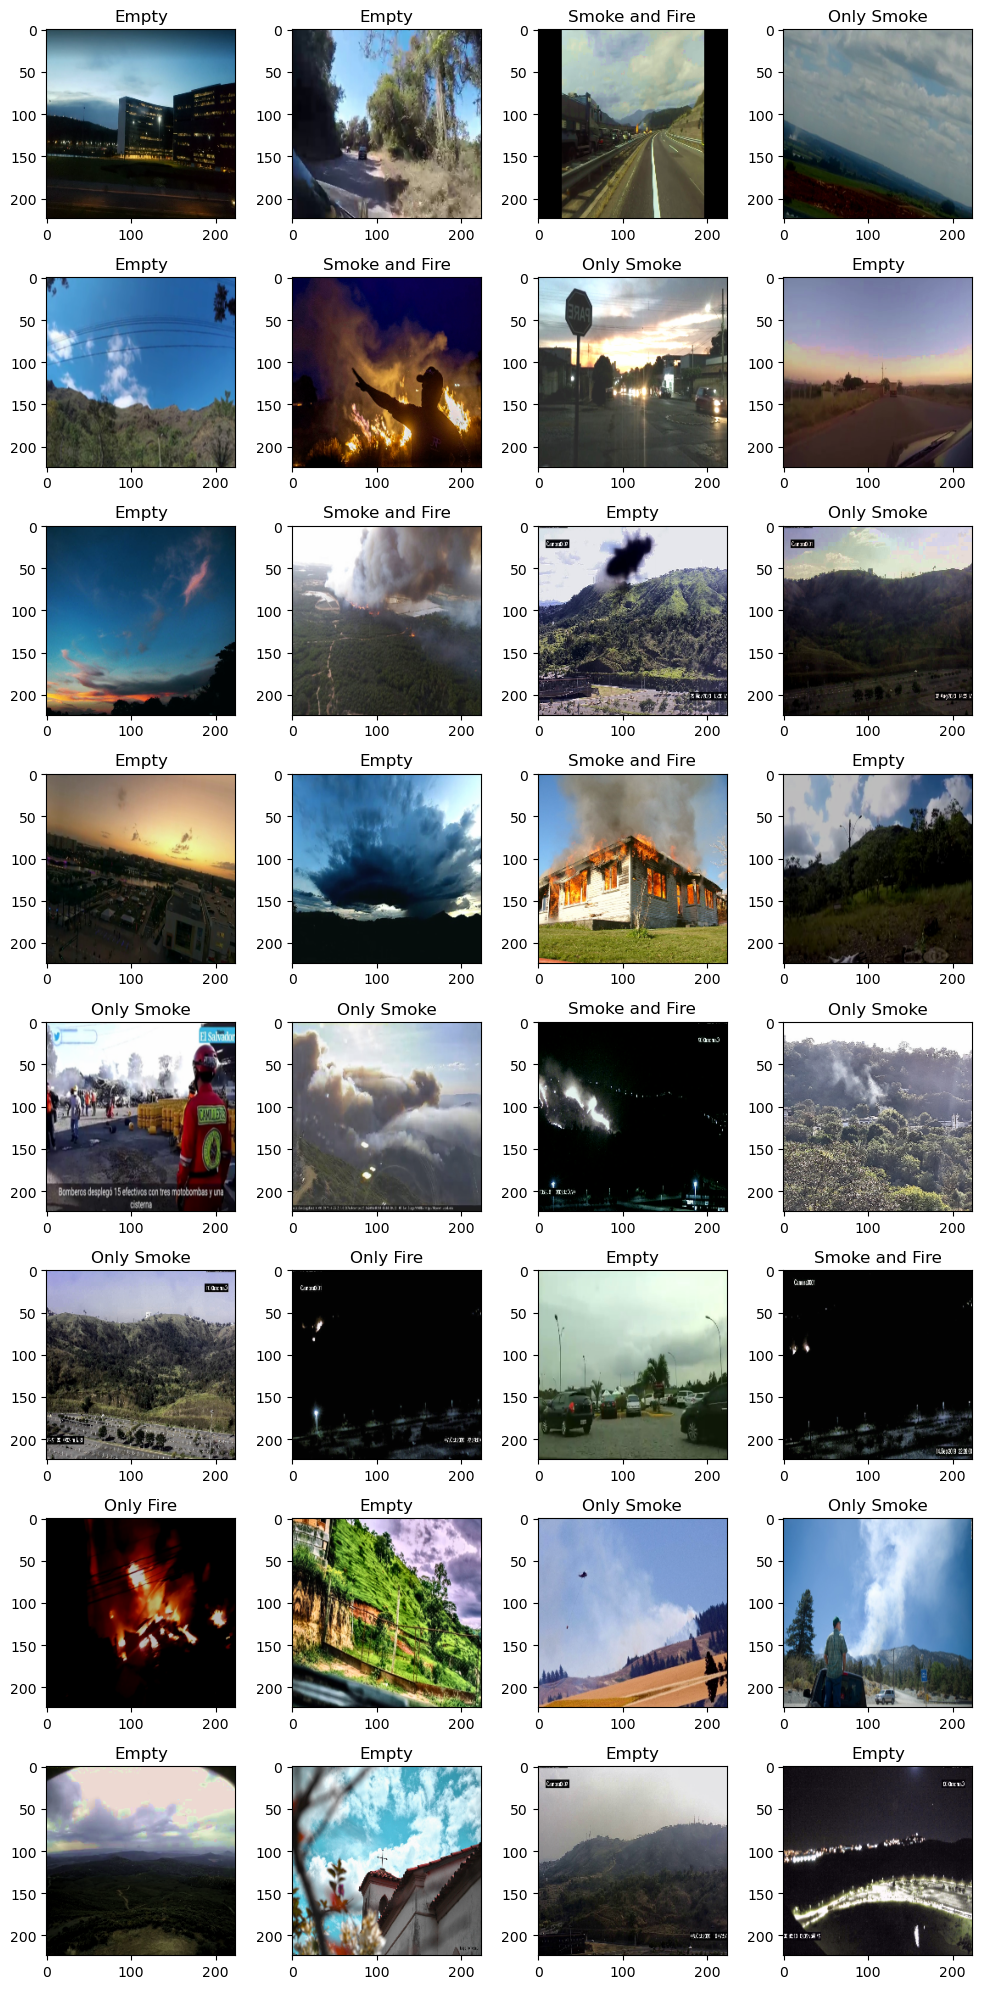

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'\tTrain dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("TEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'\tTest dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [8]:
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    #fp32_model = models.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)   
    fp32_model = models.ORIGINAL_BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)   
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(fp32_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in fp32_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(fp32_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier

Trainable parameters = 282578
Total parameters = 282578



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = fp32_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{fp32_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{fp32_model}')

Model shape is tensor([[-0.2637,  0.1629],
        [-0.3208,  0.1351],
        [-0.2955,  0.1825],
        [-0.4263,  0.1694]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
ORIGINAL_BED_CLASSIFIER(
  (model): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout2d(p=0.3, inplace=False)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout2d(p=0.3, inplace=False)
    (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv31): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
 

# Torchinfo: model summary

### FP32 Model

In [10]:
print(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
ORIGINAL_BED_CLASSIFIER                  [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
│    └─Dropout2d: 2-4                    [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 16, 112, 112]         4,608
│    └─BatchNorm2d: 2-7                  [1, 16, 112, 112]         32
│    └─ReLU: 2-8                         [1, 16, 112, 112]         --
│    └─Dropout2d: 2-9                    [1, 16, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 16, 56, 56]           --
│    └─Conv2d: 2-11                      [1, 16, 56, 56]           256
│    └─Bat

# Loss Function

In [11]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [12]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Optimizer Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [13]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [14]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr:.6f}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [15]:
if __name__ == "__main__":
       
    trained_model = train_loop(model=fp32_model)


***Start Training: 17:26:56


=== EPOCH 0/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
67.676      |38.882      |28.794      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.167      |37.058      |23.108      
SMOKE -> Precision: 0.642 - Recall: 0.554 - Accuracy: 0.637 - F1: 0.594
FIRE -> Precision: 0.645 - Recall: 0.842 - Accuracy: 0.839 - F1: 0.730

Saving model with new best validation loss: 60.167

=== EPOCH 1/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.549      |37.230      |23.320      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.567      |37.367      |19.200      
SMOKE -> Precision: 0.758 - Recall: 0.301 - Accuracy: 0.618 - F1: 0.431
FIRE -> Precision: 0.786 - Recall: 0.720 - Accuracy: 0.877 - F1: 0.751

Saving model with new best validation loss: 56.567

=== EPOCH 2/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.255      |36.182      |21.073      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.818      |34.718      |18.100      
SMOKE -> Precision: 0.769 - Recall: 0.392 - Accuracy: 0.651 - F1: 0.519
FIRE -> Precision: 0.810 - Recall: 0.739 - Accuracy: 0.888 - F1: 0.773

Saving model with new best validation loss: 52.818

=== EPOCH 3/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.237      |35.562      |19.676      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.048      |33.967      |17.081      
SMOKE -> Precision: 0.787 - Recall: 0.375 - Accuracy: 0.650 - F1: 0.508
FIRE -> Precision: 0.828 - Recall: 0.759 - Accuracy: 0.897 - F1: 0.792

Saving model with new best validation loss: 51.048

=== EPOCH 4/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.841      |34.401      |18.440      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.393      |34.358      |15.035      
SMOKE -> Precision: 0.819 - Recall: 0.349 - Accuracy: 0.650 - F1: 0.490
FIRE -> Precision: 0.840 - Recall: 0.796 - Accuracy: 0.908 - F1: 0.818

Saving model with new best validation loss: 49.393

=== EPOCH 5/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.633      |33.793      |17.840      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.543      |32.218      |14.325      
SMOKE -> Precision: 0.831 - Recall: 0.411 - Accuracy: 0.677 - F1: 0.550
FIRE -> Precision: 0.895 - Recall: 0.761 - Accuracy: 0.915 - F1: 0.823

Saving model with new best validation loss: 46.543

=== EPOCH 6/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.112      |33.757      |17.355      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.335      |32.213      |15.122      
SMOKE -> Precision: 0.808 - Recall: 0.486 - Accuracy: 0.697 - F1: 0.607
FIRE -> Precision: 0.901 - Recall: 0.755 - Accuracy: 0.915 - F1: 0.822

=== EPOCH 7/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.905      |32.541      |16.365      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.003      |29.985      |13.018      
SMOKE -> Precision: 0.836 - Recall: 0.478 - Accuracy: 0.704 - F1: 0.608
FIRE -> Precision: 0.916 - Recall: 0.798 - Accuracy: 0.929 - F1: 0.853

Saving model with new best validation loss: 43.003

=== EPOCH 8/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.019      |32.145      |15.874      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.196      |29.746      |13.450      
SMOKE -> Precision: 0.831 - Recall: 0.496 - Accuracy: 0.709 - F1: 0.622
FIRE -> Precision: 0.876 - Recall: 0.809 - Accuracy: 0.921 - F1: 0.841

=== EPOCH 9/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.367      |31.835      |15.532      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.236      |30.083      |14.153      
SMOKE -> Precision: 0.835 - Recall: 0.519 - Accuracy: 0.719 - F1: 0.640
FIRE -> Precision: 0.972 - Recall: 0.741 - Accuracy: 0.927 - F1: 0.840

=== EPOCH 10/139 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.205      |31.195      |15.011      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.351      |29.732      |14.620      
SMOKE -> Precision: 0.864 - Recall: 0.495 - Accuracy: 0.720 - F1: 0.630
FIRE -> Precision: 0.968 - Recall: 0.699 - Accuracy: 0.916 - F1: 0.812

=== EPOCH 11/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.698      |30.128      |14.570      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.461      |28.185      |11.276      
SMOKE -> Precision: 0.887 - Recall: 0.508 - Accuracy: 0.732 - F1: 0.645
FIRE -> Precision: 0.945 - Recall: 0.815 - Accuracy: 0.940 - F1: 0.875

Saving model with new best validation loss: 39.461

=== EPOCH 12/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.299      |29.354      |13.946      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.629      |26.640      |10.988      
SMOKE -> Precision: 0.853 - Recall: 0.574 - Accuracy: 0.748 - F1: 0.687
FIRE -> Precision: 0.933 - Recall: 0.827 - Accuracy: 0.940 - F1: 0.877

Saving model with new best validation loss: 37.629

=== EPOCH 13/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.983      |29.485      |13.498      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.108      |28.583      |13.525      
SMOKE -> Precision: 0.892 - Recall: 0.465 - Accuracy: 0.715 - F1: 0.611
FIRE -> Precision: 0.965 - Recall: 0.710 - Accuracy: 0.918 - F1: 0.818

=== EPOCH 14/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.549      |29.143      |13.406      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.947      |26.205      |11.742      
SMOKE -> Precision: 0.843 - Recall: 0.660 - Accuracy: 0.777 - F1: 0.740
FIRE -> Precision: 0.902 - Recall: 0.823 - Accuracy: 0.931 - F1: 0.861

=== EPOCH 15/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.282      |28.820      |13.462      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.472      |26.849      |10.622      
SMOKE -> Precision: 0.852 - Recall: 0.597 - Accuracy: 0.756 - F1: 0.702
FIRE -> Precision: 0.904 - Recall: 0.867 - Accuracy: 0.942 - F1: 0.885

Saving model with new best validation loss: 37.472

=== EPOCH 16/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.262      |28.493      |12.769      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.648      |25.942      |9.705       
SMOKE -> Precision: 0.878 - Recall: 0.580 - Accuracy: 0.759 - F1: 0.699
FIRE -> Precision: 0.938 - Recall: 0.854 - Accuracy: 0.948 - F1: 0.894

Saving model with new best validation loss: 35.648

=== EPOCH 17/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.213      |27.618      |12.595      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.259      |26.364      |11.896      
SMOKE -> Precision: 0.879 - Recall: 0.572 - Accuracy: 0.756 - F1: 0.693
FIRE -> Precision: 0.945 - Recall: 0.790 - Accuracy: 0.934 - F1: 0.861

=== EPOCH 18/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.300      |27.796      |12.504      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.561      |24.959      |9.602       
SMOKE -> Precision: 0.871 - Recall: 0.603 - Accuracy: 0.766 - F1: 0.713
FIRE -> Precision: 0.914 - Recall: 0.877 - Accuracy: 0.947 - F1: 0.895

Saving model with new best validation loss: 34.561

=== EPOCH 19/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.685      |27.342      |12.343      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.369      |23.888      |9.481       
SMOKE -> Precision: 0.843 - Recall: 0.731 - Accuracy: 0.805 - F1: 0.783
FIRE -> Precision: 0.933 - Recall: 0.850 - Accuracy: 0.945 - F1: 0.890

Saving model with new best validation loss: 33.369

=== EPOCH 20/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.690      |26.807      |11.883      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.427      |24.448      |9.979       
SMOKE -> Precision: 0.871 - Recall: 0.657 - Accuracy: 0.788 - F1: 0.749
FIRE -> Precision: 0.934 - Recall: 0.862 - Accuracy: 0.948 - F1: 0.896

=== EPOCH 21/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.795      |26.729      |12.066      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.245      |25.488      |9.757       
SMOKE -> Precision: 0.752 - Recall: 0.849 - Accuracy: 0.792 - F1: 0.797
FIRE -> Precision: 0.934 - Recall: 0.880 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 22/139 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.070      |26.329      |11.741      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.170      |24.153      |13.016      
SMOKE -> Precision: 0.898 - Recall: 0.584 - Accuracy: 0.768 - F1: 0.708
FIRE -> Precision: 0.977 - Recall: 0.743 - Accuracy: 0.929 - F1: 0.844

=== EPOCH 23/139 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.860      |25.545      |11.315      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.364      |22.507      |9.857       
SMOKE -> Precision: 0.873 - Recall: 0.695 - Accuracy: 0.805 - F1: 0.774
FIRE -> Precision: 0.925 - Recall: 0.842 - Accuracy: 0.941 - F1: 0.882

Saving model with new best validation loss: 32.364

=== EPOCH 24/139 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.481      |25.205      |11.276      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.486      |26.351      |12.135      
SMOKE -> Precision: 0.908 - Recall: 0.571 - Accuracy: 0.766 - F1: 0.701
FIRE -> Precision: 0.967 - Recall: 0.766 - Accuracy: 0.933 - F1: 0.855

=== EPOCH 25/139 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.040      |25.221      |10.819      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.336      |22.923      |10.412      
SMOKE -> Precision: 0.898 - Recall: 0.650 - Accuracy: 0.796 - F1: 0.754
FIRE -> Precision: 0.958 - Recall: 0.804 - Accuracy: 0.940 - F1: 0.874

=== EPOCH 26/139 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.313      |24.509      |10.804      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.904      |23.078      |10.826      
SMOKE -> Precision: 0.891 - Recall: 0.686 - Accuracy: 0.809 - F1: 0.775
FIRE -> Precision: 0.960 - Recall: 0.804 - Accuracy: 0.941 - F1: 0.875

=== EPOCH 27/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.102      |23.912      |10.189      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.037      |21.481      |8.556       
SMOKE -> Precision: 0.906 - Recall: 0.718 - Accuracy: 0.829 - F1: 0.802
FIRE -> Precision: 0.928 - Recall: 0.886 - Accuracy: 0.953 - F1: 0.907

Saving model with new best validation loss: 30.037

=== EPOCH 28/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.442      |23.448      |9.994       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.484      |22.817      |10.667      
SMOKE -> Precision: 0.903 - Recall: 0.666 - Accuracy: 0.805 - F1: 0.766
FIRE -> Precision: 0.968 - Recall: 0.800 - Accuracy: 0.941 - F1: 0.876

=== EPOCH 29/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.019      |23.214      |9.804       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.221      |19.565      |8.656       
SMOKE -> Precision: 0.879 - Recall: 0.797 - Accuracy: 0.849 - F1: 0.836
FIRE -> Precision: 0.928 - Recall: 0.878 - Accuracy: 0.951 - F1: 0.902

Saving model with new best validation loss: 28.221

=== EPOCH 30/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.288      |23.142      |10.147      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.065      |21.302      |8.763       
SMOKE -> Precision: 0.896 - Recall: 0.711 - Accuracy: 0.821 - F1: 0.793
FIRE -> Precision: 0.931 - Recall: 0.863 - Accuracy: 0.948 - F1: 0.896

=== EPOCH 31/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.429      |22.631      |9.797       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.591      |19.874      |8.716       
SMOKE -> Precision: 0.893 - Recall: 0.756 - Accuracy: 0.839 - F1: 0.819
FIRE -> Precision: 0.944 - Recall: 0.871 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 32/139 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.397      |22.375      |10.022      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.007      |19.982      |9.024       
SMOKE -> Precision: 0.900 - Recall: 0.750 - Accuracy: 0.840 - F1: 0.818
FIRE -> Precision: 0.958 - Recall: 0.837 - Accuracy: 0.948 - F1: 0.893

=== EPOCH 33/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.808      |22.096      |9.711       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.622      |18.325      |8.296       
SMOKE -> Precision: 0.864 - Recall: 0.851 - Accuracy: 0.864 - F1: 0.857
FIRE -> Precision: 0.946 - Recall: 0.873 - Accuracy: 0.954 - F1: 0.908

Saving model with new best validation loss: 26.622

=== EPOCH 34/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.780      |21.472      |9.307       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.112      |18.580      |9.532       
SMOKE -> Precision: 0.885 - Recall: 0.811 - Accuracy: 0.858 - F1: 0.846
FIRE -> Precision: 0.943 - Recall: 0.833 - Accuracy: 0.944 - F1: 0.885

=== EPOCH 35/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.193      |21.315      |8.879       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.754      |18.413      |8.341       
SMOKE -> Precision: 0.860 - Recall: 0.851 - Accuracy: 0.862 - F1: 0.856
FIRE -> Precision: 0.940 - Recall: 0.883 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 36/139 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.118      |21.102      |9.016       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.664      |18.141      |8.523       
SMOKE -> Precision: 0.878 - Recall: 0.830 - Accuracy: 0.863 - F1: 0.853
FIRE -> Precision: 0.940 - Recall: 0.866 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 37/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.561      |20.740      |8.821       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.966      |17.580      |8.387       
SMOKE -> Precision: 0.899 - Recall: 0.818 - Accuracy: 0.868 - F1: 0.857
FIRE -> Precision: 0.956 - Recall: 0.868 - Accuracy: 0.956 - F1: 0.910

Saving model with new best validation loss: 25.966

=== EPOCH 38/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.684      |20.792      |8.892       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.669      |17.358      |9.312       
SMOKE -> Precision: 0.868 - Recall: 0.855 - Accuracy: 0.868 - F1: 0.861
FIRE -> Precision: 0.951 - Recall: 0.831 - Accuracy: 0.945 - F1: 0.887

=== EPOCH 39/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.847      |20.264      |8.583       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.714      |18.380      |8.334       
SMOKE -> Precision: 0.911 - Recall: 0.773 - Accuracy: 0.855 - F1: 0.837
FIRE -> Precision: 0.941 - Recall: 0.876 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 40/139 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.416      |19.963      |8.453       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.112      |17.497      |8.615       
SMOKE -> Precision: 0.916 - Recall: 0.788 - Accuracy: 0.863 - F1: 0.847
FIRE -> Precision: 0.951 - Recall: 0.845 - Accuracy: 0.949 - F1: 0.895

=== EPOCH 41/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.571      |19.394      |8.177       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.474      |16.280      |8.194       
SMOKE -> Precision: 0.910 - Recall: 0.826 - Accuracy: 0.877 - F1: 0.866
FIRE -> Precision: 0.948 - Recall: 0.858 - Accuracy: 0.951 - F1: 0.901

Saving model with new best validation loss: 24.474

=== EPOCH 42/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.469      |19.269      |8.200       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.383      |16.951      |8.432       
SMOKE -> Precision: 0.876 - Recall: 0.878 - Accuracy: 0.882 - F1: 0.877
FIRE -> Precision: 0.926 - Recall: 0.874 - Accuracy: 0.949 - F1: 0.899

=== EPOCH 43/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.087      |19.170      |7.917       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.628      |16.465      |9.163       
SMOKE -> Precision: 0.914 - Recall: 0.810 - Accuracy: 0.872 - F1: 0.859
FIRE -> Precision: 0.964 - Recall: 0.832 - Accuracy: 0.948 - F1: 0.893

=== EPOCH 44/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.066      |19.221      |7.845       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.531      |15.510      |8.020       
SMOKE -> Precision: 0.886 - Recall: 0.881 - Accuracy: 0.888 - F1: 0.884
FIRE -> Precision: 0.949 - Recall: 0.865 - Accuracy: 0.953 - F1: 0.905

Saving model with new best validation loss: 23.531

=== EPOCH 45/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.919      |18.760      |8.159       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.973      |16.063      |7.910       
SMOKE -> Precision: 0.929 - Recall: 0.797 - Accuracy: 0.873 - F1: 0.858
FIRE -> Precision: 0.949 - Recall: 0.876 - Accuracy: 0.956 - F1: 0.911

=== EPOCH 46/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.758      |18.700      |8.058       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.437      |15.232      |8.205       
SMOKE -> Precision: 0.895 - Recall: 0.873 - Accuracy: 0.890 - F1: 0.884
FIRE -> Precision: 0.941 - Recall: 0.861 - Accuracy: 0.950 - F1: 0.899

Saving model with new best validation loss: 23.437

=== EPOCH 47/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.308      |18.550      |7.759       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.772      |15.978      |7.793       
SMOKE -> Precision: 0.903 - Recall: 0.848 - Accuracy: 0.883 - F1: 0.874
FIRE -> Precision: 0.934 - Recall: 0.892 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 48/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.076      |18.191      |7.885       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.374      |15.090      |7.284       
SMOKE -> Precision: 0.892 - Recall: 0.888 - Accuracy: 0.895 - F1: 0.890
FIRE -> Precision: 0.941 - Recall: 0.890 - Accuracy: 0.957 - F1: 0.915

Saving model with new best validation loss: 22.374

=== EPOCH 49/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.224      |18.464      |7.760       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.011      |15.973      |8.038       
SMOKE -> Precision: 0.906 - Recall: 0.847 - Accuracy: 0.884 - F1: 0.875
FIRE -> Precision: 0.945 - Recall: 0.868 - Accuracy: 0.953 - F1: 0.905

=== EPOCH 50/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.598      |18.155      |7.443       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.345      |16.852      |8.493       
SMOKE -> Precision: 0.910 - Recall: 0.829 - Accuracy: 0.878 - F1: 0.868
FIRE -> Precision: 0.948 - Recall: 0.852 - Accuracy: 0.950 - F1: 0.898

=== EPOCH 51/139 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.625      |18.051      |7.574       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.347      |15.544      |7.804       
SMOKE -> Precision: 0.923 - Recall: 0.843 - Accuracy: 0.891 - F1: 0.881
FIRE -> Precision: 0.954 - Recall: 0.886 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 52/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.431      |17.974      |7.456       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.292      |14.885      |8.407       
SMOKE -> Precision: 0.917 - Recall: 0.847 - Accuracy: 0.889 - F1: 0.881
FIRE -> Precision: 0.955 - Recall: 0.860 - Accuracy: 0.953 - F1: 0.905

=== EPOCH 53/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.402      |17.103      |7.300       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.645      |14.436      |8.209       
SMOKE -> Precision: 0.908 - Recall: 0.866 - Accuracy: 0.893 - F1: 0.887
FIRE -> Precision: 0.937 - Recall: 0.872 - Accuracy: 0.952 - F1: 0.903

=== EPOCH 54/139 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.396      |17.184      |7.213       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.744      |14.947      |7.798       
SMOKE -> Precision: 0.915 - Recall: 0.862 - Accuracy: 0.895 - F1: 0.888
FIRE -> Precision: 0.948 - Recall: 0.879 - Accuracy: 0.956 - F1: 0.913

=== EPOCH 55/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.173      |16.952      |7.221       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.842      |14.132      |7.710       
SMOKE -> Precision: 0.908 - Recall: 0.890 - Accuracy: 0.904 - F1: 0.899
FIRE -> Precision: 0.940 - Recall: 0.882 - Accuracy: 0.955 - F1: 0.910

Saving model with new best validation loss: 21.842

=== EPOCH 56/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.609      |16.591      |7.018       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.621      |14.904      |7.717       
SMOKE -> Precision: 0.922 - Recall: 0.844 - Accuracy: 0.891 - F1: 0.882
FIRE -> Precision: 0.955 - Recall: 0.878 - Accuracy: 0.958 - F1: 0.915

=== EPOCH 57/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.504      |16.692      |6.812       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.240      |14.713      |7.527       
SMOKE -> Precision: 0.925 - Recall: 0.839 - Accuracy: 0.889 - F1: 0.880
FIRE -> Precision: 0.929 - Recall: 0.896 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 58/139 ===
Learning Rate = 0.0001677721600000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.406      |16.541      |6.865       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.359      |14.226      |8.133       
SMOKE -> Precision: 0.920 - Recall: 0.870 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.946 - Recall: 0.866 - Accuracy: 0.952 - F1: 0.904

=== EPOCH 59/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.857      |16.233      |6.625       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.861      |13.729      |8.131       
SMOKE -> Precision: 0.909 - Recall: 0.889 - Accuracy: 0.904 - F1: 0.899
FIRE -> Precision: 0.944 - Recall: 0.873 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 60/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.919      |15.983      |6.937       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.624      |14.738      |7.886       
SMOKE -> Precision: 0.920 - Recall: 0.843 - Accuracy: 0.889 - F1: 0.880
FIRE -> Precision: 0.941 - Recall: 0.879 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 61/139 ===
Learning Rate = 0.00013421772800000008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.612      |15.652      |6.961       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.080      |14.356      |7.724       
SMOKE -> Precision: 0.928 - Recall: 0.843 - Accuracy: 0.893 - F1: 0.884
FIRE -> Precision: 0.942 - Recall: 0.886 - Accuracy: 0.956 - F1: 0.913

=== EPOCH 62/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.477      |15.663      |6.813       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.904      |13.576      |7.328       
SMOKE -> Precision: 0.918 - Recall: 0.883 - Accuracy: 0.906 - F1: 0.900
FIRE -> Precision: 0.935 - Recall: 0.887 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 20.904

=== EPOCH 63/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.030      |15.612      |6.418       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.920      |13.947      |7.972       
SMOKE -> Precision: 0.925 - Recall: 0.863 - Accuracy: 0.901 - F1: 0.893
FIRE -> Precision: 0.952 - Recall: 0.877 - Accuracy: 0.957 - F1: 0.913

=== EPOCH 64/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.687      |15.139      |6.548       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.114      |13.514      |7.600       
SMOKE -> Precision: 0.927 - Recall: 0.867 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.938 - Recall: 0.898 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 65/139 ===
Learning Rate = 0.00010737418240000007



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.797      |15.228      |6.569       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.119      |13.424      |7.696       
SMOKE -> Precision: 0.919 - Recall: 0.883 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.946 - Recall: 0.884 - Accuracy: 0.957 - F1: 0.914

=== EPOCH 66/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.156      |15.056      |6.100       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.800      |13.115      |7.685       
SMOKE -> Precision: 0.917 - Recall: 0.888 - Accuracy: 0.908 - F1: 0.902
FIRE -> Precision: 0.941 - Recall: 0.893 - Accuracy: 0.958 - F1: 0.916

Saving model with new best validation loss: 20.800

=== EPOCH 67/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.901      |14.851      |6.051       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.323      |13.405      |7.918       
SMOKE -> Precision: 0.920 - Recall: 0.886 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.935 - Recall: 0.885 - Accuracy: 0.954 - F1: 0.909

=== EPOCH 68/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.665      |14.612      |6.053       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.558      |13.426      |8.133       
SMOKE -> Precision: 0.926 - Recall: 0.871 - Accuracy: 0.904 - F1: 0.897
FIRE -> Precision: 0.942 - Recall: 0.870 - Accuracy: 0.952 - F1: 0.904

=== EPOCH 69/139 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.067      |14.952      |6.114       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.551      |13.258      |8.293       
SMOKE -> Precision: 0.919 - Recall: 0.887 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.946 - Recall: 0.868 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 70/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.085      |14.994      |6.091       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.523      |13.637      |7.886       
SMOKE -> Precision: 0.929 - Recall: 0.860 - Accuracy: 0.901 - F1: 0.893
FIRE -> Precision: 0.940 - Recall: 0.882 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 71/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.644      |14.436      |6.208       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.329      |13.110      |8.218       
SMOKE -> Precision: 0.931 - Recall: 0.871 - Accuracy: 0.907 - F1: 0.900
FIRE -> Precision: 0.943 - Recall: 0.873 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 72/139 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.534      |14.498      |6.036       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.060      |13.253      |7.807       
SMOKE -> Precision: 0.929 - Recall: 0.874 - Accuracy: 0.908 - F1: 0.901
FIRE -> Precision: 0.945 - Recall: 0.877 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 73/139 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.094      |14.090      |6.004       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.959      |13.150      |7.809       
SMOKE -> Precision: 0.927 - Recall: 0.880 - Accuracy: 0.909 - F1: 0.903
FIRE -> Precision: 0.941 - Recall: 0.882 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 74/139 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.598      |14.718      |5.881       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.900      |13.082      |7.818       
SMOKE -> Precision: 0.917 - Recall: 0.891 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.938 - Recall: 0.885 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 75/139 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.349      |14.332      |6.017       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.909      |12.862      |8.047       
SMOKE -> Precision: 0.931 - Recall: 0.883 - Accuracy: 0.913 - F1: 0.907
FIRE -> Precision: 0.941 - Recall: 0.876 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 76/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.193      |14.175      |6.017       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.620      |12.740      |7.880       
SMOKE -> Precision: 0.927 - Recall: 0.887 - Accuracy: 0.912 - F1: 0.906
FIRE -> Precision: 0.947 - Recall: 0.877 - Accuracy: 0.956 - F1: 0.911

Saving model with new best validation loss: 20.620

=== EPOCH 77/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.980      |14.065      |5.915       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.471      |12.594      |7.878       
SMOKE -> Precision: 0.928 - Recall: 0.884 - Accuracy: 0.911 - F1: 0.906
FIRE -> Precision: 0.942 - Recall: 0.876 - Accuracy: 0.954 - F1: 0.908

Saving model with new best validation loss: 20.471

=== EPOCH 78/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.909      |14.066      |5.844       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.914      |12.741      |8.173       
SMOKE -> Precision: 0.925 - Recall: 0.892 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.944 - Recall: 0.868 - Accuracy: 0.953 - F1: 0.905

=== EPOCH 79/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.957      |14.261      |5.696       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.055      |13.018      |8.037       
SMOKE -> Precision: 0.929 - Recall: 0.883 - Accuracy: 0.911 - F1: 0.906
FIRE -> Precision: 0.949 - Recall: 0.873 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 80/139 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.955      |14.042      |5.912       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.180      |13.167      |8.013       
SMOKE -> Precision: 0.935 - Recall: 0.873 - Accuracy: 0.910 - F1: 0.903
FIRE -> Precision: 0.938 - Recall: 0.877 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 81/139 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.893      |14.040      |5.853       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.163      |12.967      |8.196       
SMOKE -> Precision: 0.930 - Recall: 0.884 - Accuracy: 0.912 - F1: 0.906
FIRE -> Precision: 0.948 - Recall: 0.874 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 82/139 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.834      |13.807      |6.027       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.817      |12.783      |8.034       
SMOKE -> Precision: 0.926 - Recall: 0.886 - Accuracy: 0.911 - F1: 0.905
FIRE -> Precision: 0.941 - Recall: 0.868 - Accuracy: 0.952 - F1: 0.903

=== EPOCH 83/139 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.451      |13.856      |5.594       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.509      |13.099      |8.411       
SMOKE -> Precision: 0.928 - Recall: 0.869 - Accuracy: 0.905 - F1: 0.898
FIRE -> Precision: 0.946 - Recall: 0.864 - Accuracy: 0.952 - F1: 0.903

=== EPOCH 84/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.715      |13.689      |6.026       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.650      |12.708      |7.942       
SMOKE -> Precision: 0.924 - Recall: 0.894 - Accuracy: 0.914 - F1: 0.909
FIRE -> Precision: 0.935 - Recall: 0.891 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 85/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.531      |13.628      |5.903       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.985      |13.010      |7.975       
SMOKE -> Precision: 0.932 - Recall: 0.877 - Accuracy: 0.910 - F1: 0.904
FIRE -> Precision: 0.942 - Recall: 0.881 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 86/139 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.621      |13.835      |5.786       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.288      |13.386      |7.902       
SMOKE -> Precision: 0.935 - Recall: 0.869 - Accuracy: 0.908 - F1: 0.901
FIRE -> Precision: 0.940 - Recall: 0.880 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 87/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.446      |13.662      |5.784       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.258      |12.539      |7.719       
SMOKE -> Precision: 0.929 - Recall: 0.889 - Accuracy: 0.914 - F1: 0.909
FIRE -> Precision: 0.940 - Recall: 0.888 - Accuracy: 0.956 - F1: 0.913

Saving model with new best validation loss: 20.258

=== EPOCH 88/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.338      |13.833      |5.505       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.808      |12.759      |8.049       
SMOKE -> Precision: 0.928 - Recall: 0.885 - Accuracy: 0.912 - F1: 0.906
FIRE -> Precision: 0.938 - Recall: 0.877 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 89/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.637      |13.850      |5.787       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.106      |12.639      |8.467       
SMOKE -> Precision: 0.925 - Recall: 0.888 - Accuracy: 0.911 - F1: 0.906
FIRE -> Precision: 0.949 - Recall: 0.860 - Accuracy: 0.952 - F1: 0.903

=== EPOCH 90/139 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.115      |13.456      |5.659       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.109      |13.071      |8.038       
SMOKE -> Precision: 0.932 - Recall: 0.873 - Accuracy: 0.908 - F1: 0.901
FIRE -> Precision: 0.945 - Recall: 0.880 - Accuracy: 0.956 - F1: 0.911

=== EPOCH 91/139 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.147      |13.559      |5.587       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.066      |12.960      |8.106       
SMOKE -> Precision: 0.929 - Recall: 0.881 - Accuracy: 0.910 - F1: 0.904
FIRE -> Precision: 0.941 - Recall: 0.876 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 92/139 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.138      |13.384      |5.754       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.860      |12.736      |8.124       
SMOKE -> Precision: 0.930 - Recall: 0.887 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.944 - Recall: 0.872 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 93/139 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.630      |13.144      |5.486       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.715      |12.730      |7.984       
SMOKE -> Precision: 0.929 - Recall: 0.885 - Accuracy: 0.912 - F1: 0.906
FIRE -> Precision: 0.937 - Recall: 0.877 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 94/139 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.805      |13.187      |5.618       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.078      |12.821      |8.257       
SMOKE -> Precision: 0.932 - Recall: 0.881 - Accuracy: 0.912 - F1: 0.906
FIRE -> Precision: 0.947 - Recall: 0.868 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 95/139 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.016      |13.278      |5.738       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.601      |12.613      |7.988       
SMOKE -> Precision: 0.927 - Recall: 0.893 - Accuracy: 0.915 - F1: 0.910
FIRE -> Precision: 0.938 - Recall: 0.882 - Accuracy: 0.954 - F1: 0.909

=== EPOCH 96/139 ===
Learning Rate = 1.4411518807585605e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.453      |13.240      |5.212       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.930      |12.733      |8.197       
SMOKE -> Precision: 0.930 - Recall: 0.883 - Accuracy: 0.911 - F1: 0.906
FIRE -> Precision: 0.943 - Recall: 0.871 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 97/139 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.931      |13.504      |5.427       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.597      |12.663      |7.934       
SMOKE -> Precision: 0.927 - Recall: 0.885 - Accuracy: 0.911 - F1: 0.906
FIRE -> Precision: 0.940 - Recall: 0.886 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 98/139 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.106      |13.287      |5.819       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.446      |12.443      |8.003       
SMOKE -> Precision: 0.927 - Recall: 0.896 - Accuracy: 0.916 - F1: 0.911
FIRE -> Precision: 0.945 - Recall: 0.875 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 99/139 ===
Learning Rate = 1.1529215046068485e-05



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.179      |13.405      |5.775       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.874      |12.666      |8.207       
SMOKE -> Precision: 0.927 - Recall: 0.887 - Accuracy: 0.912 - F1: 0.907
FIRE -> Precision: 0.944 - Recall: 0.870 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 100/139 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.132      |12.657      |5.475       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.679      |12.599      |8.080       
SMOKE -> Precision: 0.926 - Recall: 0.892 - Accuracy: 0.914 - F1: 0.909
FIRE -> Precision: 0.944 - Recall: 0.877 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 101/139 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.960      |13.397      |5.563       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.164      |12.946      |8.218       
SMOKE -> Precision: 0.930 - Recall: 0.882 - Accuracy: 0.911 - F1: 0.905
FIRE -> Precision: 0.944 - Recall: 0.873 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 102/139 ===
Learning Rate = 9.223372036854789e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.052      |13.504      |5.548       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.368      |12.420      |7.948       
SMOKE -> Precision: 0.923 - Recall: 0.904 - Accuracy: 0.917 - F1: 0.913
FIRE -> Precision: 0.944 - Recall: 0.884 - Accuracy: 0.956 - F1: 0.913

=== EPOCH 103/139 ===
Learning Rate = 7.378697629483831e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.921      |13.216      |5.704       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.037      |13.028      |8.009       
SMOKE -> Precision: 0.934 - Recall: 0.874 - Accuracy: 0.910 - F1: 0.903
FIRE -> Precision: 0.942 - Recall: 0.877 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 104/139 ===
Learning Rate = 7.378697629483831e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.524      |13.132      |5.392       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.818      |12.707      |8.111       
SMOKE -> Precision: 0.929 - Recall: 0.886 - Accuracy: 0.913 - F1: 0.907
FIRE -> Precision: 0.943 - Recall: 0.875 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 105/139 ===
Learning Rate = 7.378697629483831e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.705      |13.045      |5.660       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.388      |12.525      |7.864       
SMOKE -> Precision: 0.926 - Recall: 0.897 - Accuracy: 0.916 - F1: 0.911
FIRE -> Precision: 0.938 - Recall: 0.887 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 106/139 ===
Learning Rate = 5.902958103587065e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.769      |13.170      |5.599       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.522      |12.582      |7.940       
SMOKE -> Precision: 0.925 - Recall: 0.892 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.943 - Recall: 0.884 - Accuracy: 0.956 - F1: 0.913

=== EPOCH 107/139 ===
Learning Rate = 5.902958103587065e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.722      |12.969      |5.753       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.575      |12.481      |8.094       
SMOKE -> Precision: 0.925 - Recall: 0.895 - Accuracy: 0.915 - F1: 0.910
FIRE -> Precision: 0.944 - Recall: 0.871 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 108/139 ===
Learning Rate = 5.902958103587065e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.528      |12.958      |5.571       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.836      |12.631      |8.205       
SMOKE -> Precision: 0.924 - Recall: 0.893 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.942 - Recall: 0.870 - Accuracy: 0.953 - F1: 0.905

=== EPOCH 109/139 ===
Learning Rate = 4.722366482869652e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.538      |12.996      |5.541       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.776      |12.678      |8.098       
SMOKE -> Precision: 0.927 - Recall: 0.887 - Accuracy: 0.912 - F1: 0.906
FIRE -> Precision: 0.942 - Recall: 0.875 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 110/139 ===
Learning Rate = 4.722366482869652e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.796      |13.334      |5.462       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.740      |12.637      |8.103       
SMOKE -> Precision: 0.927 - Recall: 0.891 - Accuracy: 0.914 - F1: 0.909
FIRE -> Precision: 0.947 - Recall: 0.869 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 111/139 ===
Learning Rate = 4.722366482869652e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.189      |12.758      |5.431       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.560      |12.649      |7.912       
SMOKE -> Precision: 0.928 - Recall: 0.888 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.942 - Recall: 0.884 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 112/139 ===
Learning Rate = 3.777893186295722e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.615      |12.961      |5.654       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.763      |12.734      |8.029       
SMOKE -> Precision: 0.931 - Recall: 0.883 - Accuracy: 0.912 - F1: 0.906
FIRE -> Precision: 0.941 - Recall: 0.877 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 113/139 ===
Learning Rate = 3.777893186295722e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.398      |13.013      |5.385       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 22.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.462      |12.514      |7.948       
SMOKE -> Precision: 0.925 - Recall: 0.895 - Accuracy: 0.915 - F1: 0.910
FIRE -> Precision: 0.942 - Recall: 0.880 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 114/139 ===
Learning Rate = 3.777893186295722e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.111      |12.749      |5.362       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.451      |12.639      |7.812       
SMOKE -> Precision: 0.930 - Recall: 0.885 - Accuracy: 0.912 - F1: 0.907
FIRE -> Precision: 0.941 - Recall: 0.886 - Accuracy: 0.956 - F1: 0.913

=== EPOCH 115/139 ===
Learning Rate = 3.022314549036578e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.522      |12.952      |5.571       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.798      |12.758      |8.040       
SMOKE -> Precision: 0.930 - Recall: 0.882 - Accuracy: 0.911 - F1: 0.905
FIRE -> Precision: 0.942 - Recall: 0.878 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 116/139 ===
Learning Rate = 3.022314549036578e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.650      |13.233      |5.417       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.973      |12.818      |8.156       
SMOKE -> Precision: 0.930 - Recall: 0.882 - Accuracy: 0.911 - F1: 0.905
FIRE -> Precision: 0.945 - Recall: 0.874 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 117/139 ===
Learning Rate = 3.022314549036578e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.650      |13.255      |5.395       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.576      |12.642      |7.935       
SMOKE -> Precision: 0.929 - Recall: 0.887 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.943 - Recall: 0.882 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 118/139 ===
Learning Rate = 2.4178516392292624e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.434      |13.032      |5.402       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.861      |12.716      |8.145       
SMOKE -> Precision: 0.931 - Recall: 0.881 - Accuracy: 0.911 - F1: 0.905
FIRE -> Precision: 0.940 - Recall: 0.872 - Accuracy: 0.952 - F1: 0.905

=== EPOCH 119/139 ===
Learning Rate = 2.4178516392292624e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.697      |13.208      |5.490       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.670      |12.657      |8.013       
SMOKE -> Precision: 0.928 - Recall: 0.888 - Accuracy: 0.913 - F1: 0.907
FIRE -> Precision: 0.942 - Recall: 0.877 - Accuracy: 0.954 - F1: 0.909

=== EPOCH 120/139 ===
Learning Rate = 2.4178516392292624e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.681      |13.111      |5.570       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.879      |12.784      |8.094       
SMOKE -> Precision: 0.931 - Recall: 0.884 - Accuracy: 0.912 - F1: 0.907
FIRE -> Precision: 0.941 - Recall: 0.873 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 121/139 ===
Learning Rate = 1.93428131138341e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.594      |13.150      |5.444       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.349      |13.135      |8.214       
SMOKE -> Precision: 0.936 - Recall: 0.874 - Accuracy: 0.911 - F1: 0.904
FIRE -> Precision: 0.943 - Recall: 0.871 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 122/139 ===
Learning Rate = 1.93428131138341e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.543      |13.112      |5.430       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 22.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.757      |12.625      |8.132       
SMOKE -> Precision: 0.928 - Recall: 0.892 - Accuracy: 0.915 - F1: 0.910
FIRE -> Precision: 0.942 - Recall: 0.874 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 123/139 ===
Learning Rate = 1.93428131138341e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.507      |13.075      |5.432       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 22.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.887      |12.831      |8.056       
SMOKE -> Precision: 0.932 - Recall: 0.877 - Accuracy: 0.910 - F1: 0.904
FIRE -> Precision: 0.940 - Recall: 0.880 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 124/139 ===
Learning Rate = 1.547425049106728e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.757      |13.141      |5.616       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.546      |12.677      |7.869       
SMOKE -> Precision: 0.927 - Recall: 0.889 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.941 - Recall: 0.887 - Accuracy: 0.956 - F1: 0.913

=== EPOCH 125/139 ===
Learning Rate = 1.547425049106728e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.426      |13.071      |5.355       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.776      |12.735      |8.041       
SMOKE -> Precision: 0.927 - Recall: 0.889 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.943 - Recall: 0.877 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 126/139 ===
Learning Rate = 1.547425049106728e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.334      |12.944      |5.390       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.813      |12.722      |8.091       
SMOKE -> Precision: 0.929 - Recall: 0.887 - Accuracy: 0.913 - F1: 0.907
FIRE -> Precision: 0.943 - Recall: 0.877 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 127/139 ===
Learning Rate = 1.2379400392853825e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.761      |13.395      |5.366       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 22.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.135      |12.773      |8.362       
SMOKE -> Precision: 0.930 - Recall: 0.883 - Accuracy: 0.912 - F1: 0.906
FIRE -> Precision: 0.950 - Recall: 0.865 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 128/139 ===
Learning Rate = 1.2379400392853825e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.393      |13.070      |5.323       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 22.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.922      |12.829      |8.094       
SMOKE -> Precision: 0.932 - Recall: 0.882 - Accuracy: 0.913 - F1: 0.907
FIRE -> Precision: 0.946 - Recall: 0.875 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 129/139 ===
Learning Rate = 1.2379400392853825e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.441      |12.951      |5.490       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 22.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.988      |12.868      |8.120       
SMOKE -> Precision: 0.932 - Recall: 0.878 - Accuracy: 0.910 - F1: 0.904
FIRE -> Precision: 0.944 - Recall: 0.874 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 130/139 ===
Learning Rate = 1e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.852      |13.282      |5.570       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.825      |12.695      |8.130       
SMOKE -> Precision: 0.930 - Recall: 0.889 - Accuracy: 0.915 - F1: 0.909
FIRE -> Precision: 0.942 - Recall: 0.873 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 131/139 ===
Learning Rate = 1e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.417      |13.066      |5.351       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.899      |12.747      |8.153       
SMOKE -> Precision: 0.929 - Recall: 0.883 - Accuracy: 0.911 - F1: 0.905
FIRE -> Precision: 0.941 - Recall: 0.875 - Accuracy: 0.953 - F1: 0.907

=== EPOCH 132/139 ===
Learning Rate = 1e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.595      |12.967      |5.627       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.739      |12.708      |8.031       
SMOKE -> Precision: 0.930 - Recall: 0.889 - Accuracy: 0.914 - F1: 0.909
FIRE -> Precision: 0.946 - Recall: 0.877 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 133/139 ===
Learning Rate = 1e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.352      |12.898      |5.454       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.081      |12.777      |8.304       
SMOKE -> Precision: 0.931 - Recall: 0.884 - Accuracy: 0.912 - F1: 0.907
FIRE -> Precision: 0.950 - Recall: 0.867 - Accuracy: 0.954 - F1: 0.906

=== EPOCH 134/139 ===
Learning Rate = 1e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.010      |13.371      |5.638       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 22.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.117      |12.783      |8.334       
SMOKE -> Precision: 0.930 - Recall: 0.885 - Accuracy: 0.912 - F1: 0.907
FIRE -> Precision: 0.943 - Recall: 0.868 - Accuracy: 0.952 - F1: 0.904

=== EPOCH 135/139 ===
Learning Rate = 1e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.464      |12.894      |5.570       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 22.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.878      |12.828      |8.050       
SMOKE -> Precision: 0.932 - Recall: 0.884 - Accuracy: 0.913 - F1: 0.907
FIRE -> Precision: 0.939 - Recall: 0.879 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 136/139 ===
Learning Rate = 1e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.489      |13.015      |5.474       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 22.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.489      |12.585      |7.904       
SMOKE -> Precision: 0.926 - Recall: 0.898 - Accuracy: 0.916 - F1: 0.911
FIRE -> Precision: 0.939 - Recall: 0.890 - Accuracy: 0.957 - F1: 0.914

=== EPOCH 137/139 ===
Learning Rate = 1e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.257      |12.935      |5.322       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 23.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.646      |12.621      |8.025       
SMOKE -> Precision: 0.927 - Recall: 0.890 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.942 - Recall: 0.878 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 138/139 ===
Learning Rate = 1e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.653      |13.222      |5.431       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 22.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.542      |13.241      |8.300       
SMOKE -> Precision: 0.939 - Recall: 0.865 - Accuracy: 0.908 - F1: 0.900
FIRE -> Precision: 0.948 - Recall: 0.870 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 139/139 ===
Learning Rate = 1e-06



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.724      |13.025      |5.699       



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 22.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.440      |12.567      |7.873       
SMOKE -> Precision: 0.930 - Recall: 0.889 - Accuracy: 0.914 - F1: 0.909
FIRE -> Precision: 0.935 - Recall: 0.891 - Accuracy: 0.956 - F1: 0.912

***Script finished: 18:28:52

Time elapsed: 1:01:56.084045
